# Interpreting your Machine Learning Model : Why and How

[ _A tutorial made during the_ __[MLcourse.ai course](https://mlcourse.ai/)__ - 04/2019 - v1]

`Christophe Rigon > datacog@free.fr`

From https://github.com/cog-data/ML_Interpretability_tutorial

Modified on 2022-11-16 & 2023-03-14 by HK Turesson


***

>_"models are opinions embedded in mathematics" - Cathy O'Neil (mathematician, data scientist and author of the famous "Weapons of Math Destruction")_

>_"Science without conscience is but the ruin of the Soul" - Rabelais (who first quoted the word "automaton" in french during the 16th century)_



<img src="img/mli_fun.jpg" alt="machine-learning-interpretability-fun" title="MLI Funny" height="228" width="405"/>

Machine Learning Interpretability is a hot and crucial subject: machine learning algorithms are everywhere, becoming more and more ubiquitous, complex and efficient, and sometimes treated like __black boxes__. They have already, and will have in the future, more and more impact on our society and our everyday life. As (future) Data Scientist / Machine Learning Engineers, even if we clearly don't need interpretability all the time, I think we have a social and professional ethical duty trying to design models as **fair, accountable and transparent** as possible. Meaning : unbiasedness/not discriminating, giving reliable results and being able to be queried to validate predictive decisions.The European GDRP (General Data Protection Regulation) resolution testifies to a citizen "right to explanation" of algorithmic decisions that "significantly" affect any individual. Further more, interpreting our machine learning processes could give us valuable insights for :

- debugging
- informing feature engineering
- model comparisons
- driving future data collection
- informing human decision-making
- and generally for better communication and trust building.

The intention of this tutorial is twofold :
- to give a basic introduction to the subject, looking at different strategies for tackling the potential "black-box" problem in a **model-agnostic** fashion. 
- to have a practical grasp on some of the main frameworks actually available for machine learning interpretability like __ELI5, LIME, SHAP__ and __PDPbox__. 

After loading and providing a [description of the data](#descrip_data), a [quick EDA](#eda), and [training/evaluating our model](#model), we will be exploring more in depth differents interpretation techniques like : 

1. [Feature Importance (without and with permutation)](#feature_importance)
2. [Partial Dependence Plots (PD plot)](#pd_plots) &  [Individual Conditional Expectation (ICE) plots](#ice_plots)
3. [Model Prediction Explanation with SHAP values](#shap)
4. [Dependence and Interaction Plots (SHAP)](#shap_plots)
5. [Further readings and conclusion](#further_readings)

We will work :
- on a real-world dataset about Red Wine Quality (after all ethics can, and should also be convivial ;)) 
- with an XGBoost model, which is a complex optimized distributed gradient boosting library providing a parallel tree boosting algorithm 
- and the learning task will be a classical supervised classification with binarized classes.



# Load dependencies

In [1]:
### Elementary my Dear Watson...
import pandas as pd
import numpy as np

### Graphic libraries
import matplotlib.pyplot as plt
import seaborn as sns 

### Some Scikit-learn utils
from sklearn.model_selection import train_test_split

### Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc

### Models
from xgboost import XGBClassifier, plot_importance

########################################################
### For an easier workflow, Interpretability libraries
### will be installed/loaded on the fly of the tutorial
########################################################

### Some cosmetics add-ons
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline


/var/folders/9w/090_7gb54d54ppm4sfqk8xgr0000gn/T/ipykernel_19015/1418875336.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Load the Red Wine Quality Dataset

The Red Wine Quality dataset can be downloaded __[on this Kaggle page](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009)__ or via the __[UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/wine+quality)__.

"This datasets is related to red variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference __[Cortez et al., 2009](http://dx.doi.org/10.1016/j.dss.2009.05.016)__. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.)."

Upload `E-ML_data.zip` and unzip it.

In [2]:
!unzip 'E-ML_data.zip'

Archive:  E-ML_data.zip
replace data/test.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Load the data to a Pandas dataframe.

In [3]:
# loading the csv dataset in a dataframe
df_raw = pd.read_csv('data/winequality-red.csv')
df_raw.shape

(1599, 12)

> I have chosen a small and clean dataset (1599 rows x 11+1 variables) for quick and easy (pre)processing.

<a name="descrip_data"></a>
## Data Description

**Input variables (based on physicochemical tests)**:
1. _fixed acidity_ : most acids involved with wine or fixed or nonvolatile (do not evaporate readily).
2. _volatile acidity_ : the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste.
3. _citric acid_ : found in small quantities, citric acid can add 'freshness' and flavor to wines.
4. _residual sugar_ : the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet.
5. _chlorides_ : the amount of salt in the wine.
6. _free sulfur dioxide_ : the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine.
7. _total sulfur dioxide_ : amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine.
8. _density_ : the density of water is close to that of water depending on the percent alcohol and sugar content.
9. _pH_ : describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale.
10. _sulphates_ : a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant.
11. _alcohol_ : the percent alcohol content of the wine.

**Output variable (based on sensory data)**:
12. _quality_ : score between 0 and 10 given by human wine tasters.
<br><br><br>

In [4]:
# Let's visually check the first lines of our wine collection
df_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
# types of data
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
# Synthetic descriptive statistics
df_raw.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


> Reminder: the last attribute, ie 'quality', is our target/independant variable

In [7]:
# make for security a copy of the original dataframe before further processing 
wines = df_raw.copy()

<a name="eda"></a>
# Quick EDA and Visualization

Exploration data analysis and visualization are the **first tools** for interpreting and getting latent insights from data. They help us in identifying key features and meaningful representations, even with large datasets with for exemple dimensionality reduction techniques (PCA, t-SNE, etc). 

So let's now make a quick exploration data analysis to see how the data are distributed and correlated. 

In [8]:
# Extracting our target variable 
# and creating a usefull feature list of dependent variables
target = 'quality'
features_list = list(wines.columns)
features_list.remove(target)
features_list

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

## Univariate Analysis (features and target 'quality')

### Features distributions

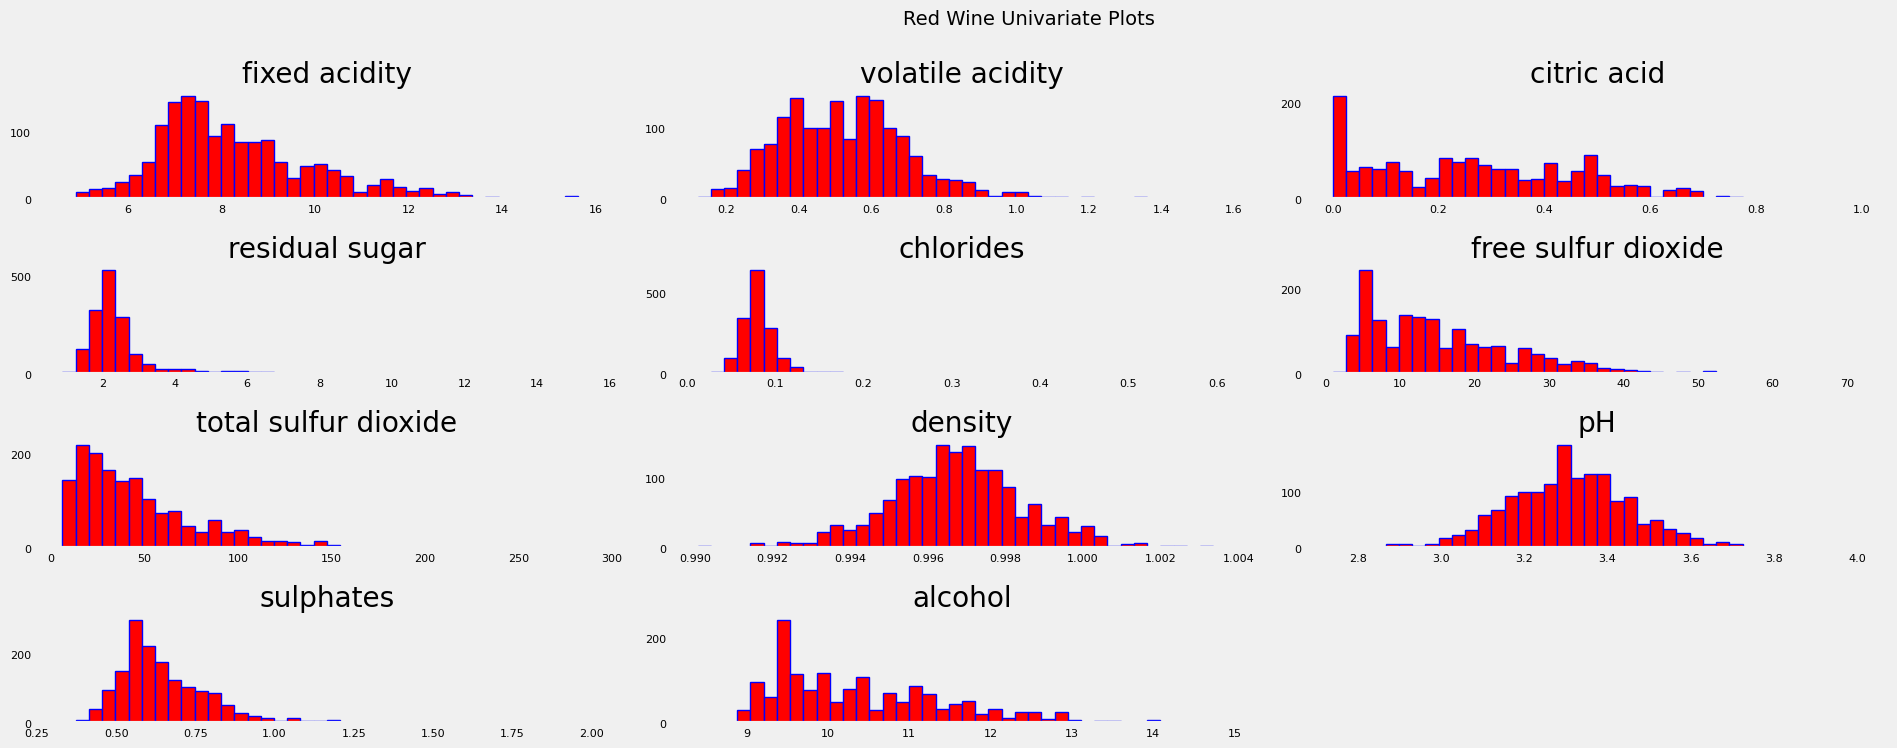

In [9]:
wines[features_list].hist(bins=40, edgecolor='b', linewidth=1.0,
                          xlabelsize=8, ylabelsize=8, grid=False, 
                          figsize=(16,6), color='red')    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
plt.suptitle('Red Wine Univariate Plots', x=0.65, y=1.25, fontsize=14);  

> We can notice that some features, like 'sulfur dioxide' or 'sulphates' for exemple, have a right skewed distribution and should, in a real context, probably be engineered into their log forms for better results.

### Target distribution

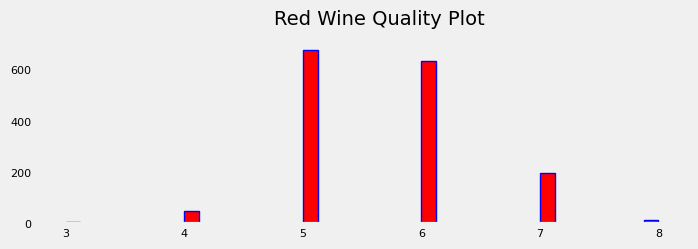

In [10]:
wines[target].hist(bins=40, edgecolor='b', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False, figsize=(6,2), color='red')    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
plt.suptitle('Red Wine Quality Plot', x=0.65, y=1.25, fontsize=14);  

## Multivariate Analysis

### Correlation matrix

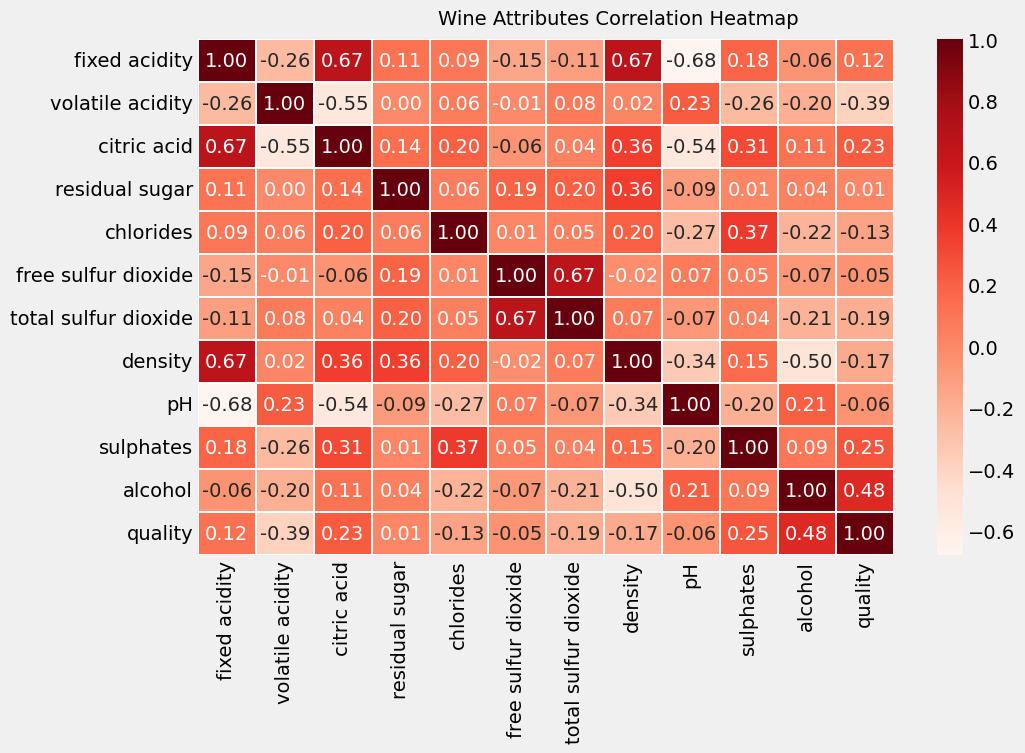

In [11]:
# for visualizing correlations
f, ax = plt.subplots(figsize=(10, 6))
corr = wines.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="Reds",fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

We can see that the alcohol level has the strongest postive correlation (0.48) with the quality notation.

There is also an understandable negative correlation between 'pH' and the 'fixed acidity' of the wine: 
- the pH is the mesure of acidity/basicity with a scale between 0 (very acid) and 14 (very basic) with a midscale at 7 (neutral)
- the definition of pH is the negative log of H+ ion (hydrogen ion)
- so the more acidic is a solution, the more the concentration of H+ is hight, the more pH tends toward 0.
- as indicated in the data description, most wines are acidic and have a pH of 3-4

## Bivariate Features vs Target 

### exemple : 'alcohol' vs 'quality' plot : 

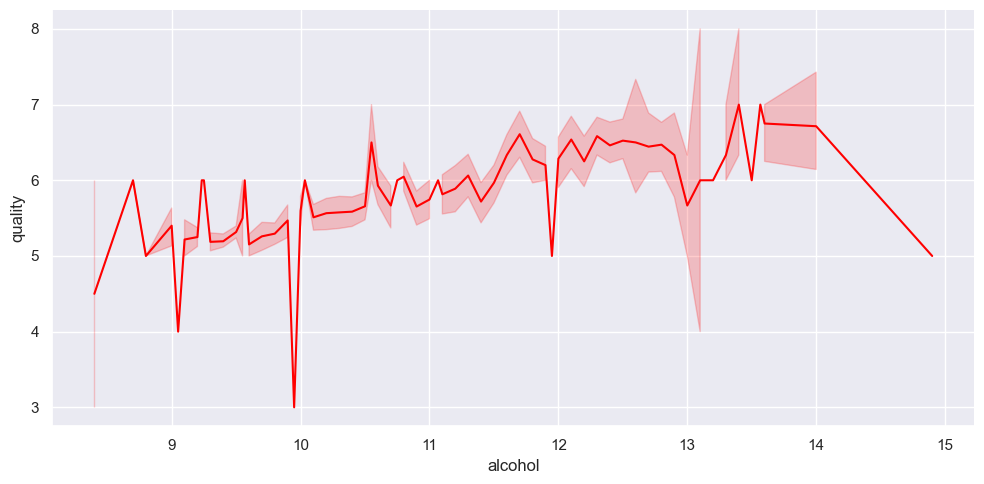

In [12]:
sns.set()
sns.relplot(data=wines, x='alcohol', y=target, kind='line', height=5, aspect=2, color='red')

> We can visualy confirm here the global positve correlation seen precedently between the 'alcohol' level (< 14) and the final quality score. Of course, feel free to try other features.

# Building Train and Test Datasets

Now for sake of simplicity let's transform our target data to a binary classification problem ('Low' vs 'Hight' quality wine) and build our train and test datasets on a classical 70/30 ratio.

In [13]:
# create our separate target vector 
y = wines.pop('quality')

# mapping the target to a binary class at quality = 5
y = y.apply(lambda x: 0 if x <= 5 else 1)

# quickly check that we have a balanced target partition
y.sum() / len(y)

0.5347091932457786

In [14]:
# building train/test datasets on a 70/30 ratio
X_train, X_test, y_train, y_test = train_test_split(wines, y, test_size=0.3, random_state=33)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

<a name="model"></a>
# Training our classification model

We will now instantiate and train an out-of-the-box **XGBoost classification model** on our train data

In [15]:
%time

# ML in two lines ;)
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_train, y_train)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=33, ...)

# Model Performance Evaluation

Now let's test our model and evaluate how it has performed with its predictions on the test data. We won't perform here any cross-validation on our model, as one should probably do in a real context.

# Making predictions on the test data and performance evaluation

## Prediction

In [16]:
# make predictions for test data
xgb_predictions = xgb.predict(X_test)

## Evaluation of performance

### Accuracy, Precision/Recall, F1 Metrics & Confusion matrix

In [17]:
# We design a simple classification evaluative function
def evaluation_scores(test, prediction, target_names=None):
    print('Accuracy:', np.round(metrics.accuracy_score(test, prediction), 4)) 
    print('-'*60)
    print('classification report:\n\n', metrics.classification_report(y_true=test, y_pred=prediction, target_names=target_names)) 
    
    classes = [0, 1]
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=test, y_pred=prediction, labels=classes)
    cm_frame = pd.DataFrame(data=cm, columns=pd.MultiIndex(levels=[['Predicted:'], classes], codes=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], codes=level_labels))
    
    print('-'*60)
    print('Confusion matrix:\n')
    print(cm_frame) 

In [18]:
# Evaluate predictions
evaluation_scores(y_test, xgb_predictions, target_names=['Low Quality', 'Hight Quality'])

Accuracy: 0.7708
------------------------------------------------------------
classification report:

                precision    recall  f1-score   support

  Low Quality       0.74      0.78      0.76       221
Hight Quality       0.80      0.76      0.78       259

     accuracy                           0.77       480
    macro avg       0.77      0.77      0.77       480
 weighted avg       0.77      0.77      0.77       480

------------------------------------------------------------
Confusion matrix:

          Predicted:     
                   0    1
Actual: 0        172   49
        1         61  198


### AUC / ROC Curve

AUC / ROC Curve is probably a better evaluations for this classification task :

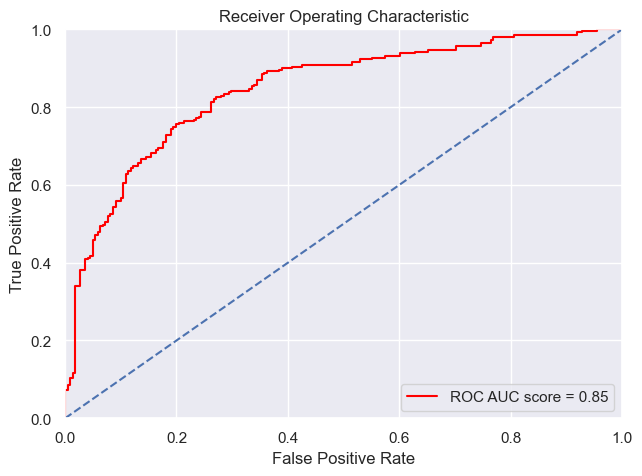

In [19]:
# calculate the FPR and TPR for all thresholds of the classification
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

> So : F1 = 0.75 and AUC = 0.83 : well, not too bad without any tuning or feature engineering.

<br><br>
>>> Now let's dive into the **interpretation of our model**:

# The trade-off Accuracy / Interpretability

In general machine learning design there is well known trade-offs between the bias and the variance of a model, or between precision and recall in classification algorithms for exemple.

Similarly, in ML Interpretability, there is the **Accuracy / Interpretability trade-off** rule of thumb which states that generally, the more accurate is a model (or a model of models, like ensemble's bagging and boosting), the more complex it is and so the more difficult it is to interpret it's outputs.

<img src="img/accuracy_interpretability.png" alt="accuracy-interpretability-trade-off" title="The Accuracy vs Interpretability trade-off" />

More, accuracy cannot stand alone for buiding trust on our models because of possible overfitting of the model, correlations of the features and noise in the data.

So we need more sophisticated metrics and analytics than just plain accuracy of the results.

# Default Model Interpretation Methods

__Non-parametrics models__ like tree-based models as XGBoost are more difficult to interpret because their total number of parameters is not fixed and will grow with the volume of data used for the training. Parametrics models (e.g. logistic regression) offers a contrario a first level of interpretation by the way of their coefficients (but in fact even this is not completely trivial). In that case, regularization techniques like L1-regularization/LASSO can be usefull to reduce the feature space and improving the interpretability of the model. For non-parametric models, fortunately, many of them like XGBoost give an access to interpretation methods like feature importance for helping us to understand the inner evaluation of the model for making his predictions.

<a name="feature_importance"></a>
## Feature importance

To interpret a model, we basically need to know :

- which features are the most important in the model
- the effect of each feature on a particular prediction
- the effects of each feature over a large number of predictions
    
Native global feature importance calculations that come with XGBoostare are based on the following parameters :

- Feature Weights: based on the number of times a feature appears in a tree across the ensemble of trees
- Coverage: the average coverage (number of samples affected) of splits which use the feature
- Gain: the average gain of splits which use the feature

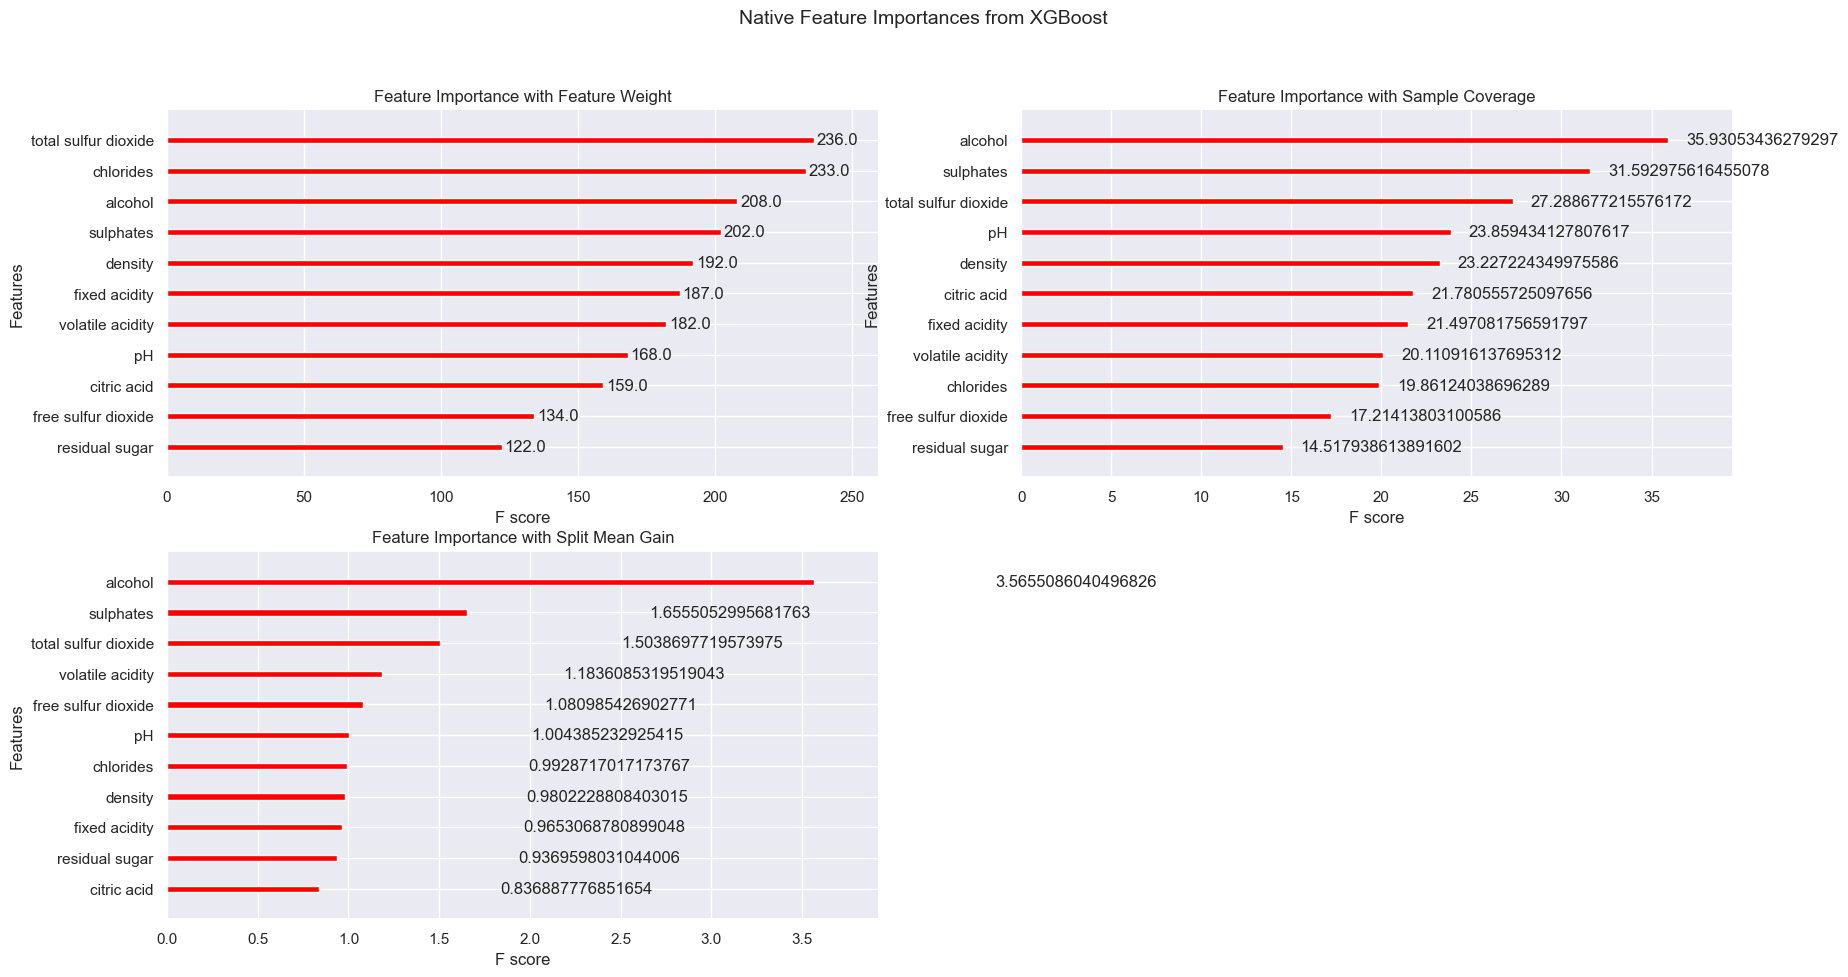

In [20]:
# ploting XGBoost default feature importances
fig = plt.figure(figsize = (18, 10))
title = fig.suptitle("Native Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2, 2, 1)
plot_importance(xgb, importance_type='weight', ax=ax1, color='red')
ax1.set_title("Feature Importance with Feature Weight");

ax2 = fig.add_subplot(2, 2, 2)
plot_importance(xgb, importance_type='cover', ax=ax2, color='red')
ax2.set_title("Feature Importance with Sample Coverage");

ax3 = fig.add_subplot(2, 2, 3)
plot_importance(xgb, importance_type='gain', ax=ax3, color='red')
ax3.set_title("Feature Importance with Split Mean Gain");

> As you can see, features are ordered in differents ways by these different criterions. We need a more **consistent** way of doing so. As we will see later, Shapley values for exemple offer us such a consistent way.

#  ELI5 Model Interpretation

According to their documentation, __[ELI5](https://github.com/TeamHG-Memex/eli5)__ ("Explain Like I'm 5") is a Python library which helps to debug machine learning classifiers and regressors and explain their predictions in an easy to understand an intuitive way. ELI5 is a good starting point and support tree-based and parametric/linear models and also text processing and HashingVectorizer utilities from scikit-learn but **doesn't support true model-agnostic interpretations**.

## Installation

In [2]:
pip install eli5


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import eli5
from eli5.sklearn import PermutationImportance

ModuleNotFoundError: No module named 'distutils'

## Feature Importances

With XGBoost, ELI5 just use the same native feature importances computation methods (with the default "gain" parameter) which we have just seen earlier and  give us an easy and ergonomic way of displaying it with the `eli5.show_weights` method.

In [ ]:
eli5.show_weights(xgb.get_booster())

## Explaining Model Prediction Decisions with ELI5

To make random forest predictions more interpretable, every prediction of the model can be presented as a sum of feature contributions (plus the bias), showing how the features lead to a particular prediction. ELI5 does it by showing weights for each feature depicting how influential it might have been in contributing to the final prediction decision across all trees. This is a good step in direction of model-agnostic interpretation but not entirely model-agnostic like, we will see it later, for LIME.

Let's examine individual data-point predictions, one for each class ("0" : quality wine scored <= 5 with a label of "Low Quality" wine, and "1" with score > 5 and a label of "Hight Quality") with the `eli5.show_prediction` method.

### Predicting when a particular wine quality will be <= 5 ('Low Quality')

In [ ]:
wine_nb = 0
print('Reference:', y_test.iloc[wine_nb])
print('Predicted:', xgb_predictions[wine_nb])
eli5.show_prediction(xgb.get_booster(), X_test.iloc[wine_nb], 
                     feature_names=list(wines.columns), show_feature_values=True)

> In this successfully individual prediction, the top 3 influential features seems to be, after the bias, the pH, total sulfur dioxide, and chlorides.

> NB: you can understand "BIAS" here as the expected average score output by the model, based on the distribution of the training set. If you want more explanation about his meaning in Eli5 and in this context (XGBoost model), you can check out this [Stackoverflow thread](https://stackoverflow.com/questions/49402701/eli5-explaining-prediction-xgboost-model).

### Predicting when a particular wine quality will be > 5 ('Hight Quality')

In [ ]:
wine_nb = 4
print('Reference:', y_test.iloc[wine_nb])
print('Predicted:', xgb_predictions[wine_nb])
eli5.show_prediction(xgb.get_booster(), X_test.iloc[wine_nb], 
                     feature_names=list(wines.columns), show_feature_values=True)

> And in this one, sulfate, total sulfur dioxide, and volatile acidity seems to be prevalent.

> Notice how a feature like 'sulphates' play an opposite influential role in explaining model prediction between the two classes and acts like a flag in these two particular examples .

### Features Permutation Importances

Eli5 provides a way to compute feature importances for any black-box estimator by measuring how score decreases when a feature is not available; the method is also known as “permutation importance” or “Mean Decrease Accuracy (MDA). This is **more reliable** but this technique is **computationally slow** with a big number of features.

> __Tip:__ As in our case, If you don’t have a separate held-out dataset, you can fit `PermutationImportance` on the same data as used for training; this still allows to inspect the model, but doesn’t show which features are important for **generalization**. So you'd better use your _validation dataset_, if you have one, for computing your features permutation importances.

In [ ]:
%time

# we need to retrain a new model with arrays
# as eli5 has a bug with Dataframes and XGBoost
# cf. https://github.com/TeamHG-Memex/eli5/pull/261
xgb_array = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb_array.fit(X_train.values, y_train)

In [ ]:
feat_permut = PermutationImportance(xgb_array, random_state=33).fit(X_train.values, y_train)
eli5.show_weights(feat_permut, feature_names=features_list)

> You can compare this result with the basic feature classification (ie without permutation). What are the differences ? What can you infer about the reliability of these features ?

***

<a name="shap"></a>
# Model Interpretation with SHAP

**SHAP (SHapley Additive exPlanations)** is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on what they claim! (check out the [SHAP NIPS paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) for details).

SHAP values can explain the output of any machine learning model but for complex ensemble models it can be slow. SHAP has c++ implementations supporting  *XGBoost*, *LightGBM*, *CatBoost*, and *scikit-learn* tree models.

SHAP (SHapley Additive exPlanations) assigns each feature an importance value for a particular prediction. Its novel components include: the identification of a new class of additive feature importance measures, and theoretical results showing there is a unique solution in this class with a set of desirable properties. Typically, SHAP values try to explain the output of a model (function) as a sum of the effects of each feature being introduced into a conditional expectation. Importantly, for non-linear functions the order in which features are introduced matters. The SHAP values result from averaging over all possible orderings. Proofs from game theory show this is the only possible consistent approach. 

An intuitive way to understand the Shapley value is the following: The feature values enter a room in random order. All feature values in the room participate in the game (= contribute to the prediction). The Shapley value __$ϕ_{ij}$__ is the average marginal contribution of feature value __$x_{ij}$__ by joining whatever features already entered the room before, i.e.

$$\phi_{ij}=\sum_{\text{All.orderings}}val(\{\text{features.before.j}\}\cup{}x_{ij})-val(\{\text{features.before.j}\})$$

The following figure from the KDD 18 paper, [_Consistent Individualized Feature Attribution for Tree Ensembles_](https://arxiv.org/pdf/1802.03888.pdf) summarizes this in a nice way!

![](https://i.imgur.com/6Rc1dsa.png)

Let's now dive into SHAP and leverage it for interpreting our model:

## Installation

In [ ]:
!pip install shap

In [ ]:
# pip install shap
import shap

# load JS visualization code to notebook
shap.initjs()

## Explain predictions with SHAP

Shapley value is the average contribution of features which are predicting in different situation.

SHAP provides multiple explainers for different kind of models.

- TreeExplainer: Support XGBoost, LightGBM, CatBoost and scikit-learn models by Tree SHAP.
- DeepExplainer (DEEP SHAP): Support TensorFlow and Keras models by using DeepLIFT and Shapley values.
- GradientExplainer: Support TensorFlow and Keras models.
- KernelExplainer (Kernel SHAP): Applying to any models by using LIME and Shapley values.

For more information about the Shapley values explanations check out [Christoph Molnar's book chapter on Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html) 

So let's play with the Tree SHAP implementation integrated into XGBoost to explain the test dataset. 

In [ ]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

In [ ]:
X_shap = pd.DataFrame(shap_values)
X_shap.tail()

We get a matrix of SHAP values with the same shape as the original X_test set. Each row sums to the difference between the model output for that sample and the expected value of the model output (which is stored as `expected_value` attribute of the explainer). Typically this difference helps us in explaining why the model is inclined on predicting a specific class outcome.

In [ ]:
print('Expected Value: ', explainer.expected_value)

## Feature Importances with SHAP

This basically takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar", color='red')

### Predicting when a particular wine quality will be <= 5 ('Low Quality')

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

> Reminder : features pushing the prediction higher than the base value are shown in red, those pushing the prediction lower are in blue.

> SHAP gives a nice reasoning below showing which features were the most influential in the model taking the correct decision of predicting that this wine will be scored as 'Low Quality'. The above explanation shows features each contributing to push the model output from the 'base value' (the average model output over the training dataset we passed) to the actual model output.

![SHAP]("https://drive.google.com/file/d/1kbpHWf0LJuy0BwgnjQM3g4XgIQmoRrL0")

### Predicting when a particular wine quality will be > 5 ('Hight Quality')

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[4,:], X_test.iloc[4,:])

![SHAP 2]("https://drive.google.com/file/d/1hJZZ_0-UlFTwyu68KUaewBPM0XYsVNKz")

## Visualizing and explaining multiple predictions

SHAP can build beautiful interactive plots which can visualize and explain multiple predictions at once. Here we visualize model prediction decisions for the first 1000 test data samples.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test.iloc[:1000,:])

> __Tip__: Notice the drop-down menus at the top of the graph with multiple display and ordering options and also on the left for isolating and highlighting multiple or individual features effects.

> The above visualization can be interacted with in multiple ways. The visualization shows for exemple some interesting model prediction pattern decisions. For exemple :
>
>- The first 90 test samples all probably are classified as 'Hight Quality' wines and that have a hight alcohol degree (> 11.3) that you can highlight by choosing in the left menu 'alcohol effects'
>- If you display the 'alcohol' feature with the top drop-down menu, you can confirm that the alcohol level begin to play an important role in pushing upward the prediction at a level around 11.3.
>- for 'pH', we can confirm a behavioral shift of the model after 3.5, as seen before. 

> What about 'sulphates' and 'total sulfur dioxide' that we saw before ? Does it confirm the first hypotheses you made with the PD plot ?

I think you would agree that it's definitely interesting to see how we can find out patterns in SHAP displays which lead us to have a better understanding why the model is making specific decisions and help us being able to provide explanations for them.

## SHAP Summary Plot

A SHAP value for a feature of a specific prediction represents how much the model prediction changes when we observe that feature.

SHAP also enables us to use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. 

In [ ]:
shap.summary_plot(shap_values, X_test)

> Notice that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

> It is interesting to confirm again that hight values of 'alcohol' play positive important role in the final prediction, and hight values of 'total sulfur dioxide' seems a contrario to have a negative impact on predicting "hight quality" wines.

## SHAP Dependence Plots

SHAP dependence plots show the effect of a single (or two) feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature can be chosen for coloring to highlight possible interactions.

### PD plot of 'pH' (and influence of 'fixed acidity') affecting model prediction

We can use the `dependence_plot` method for ploting the effect of a feature on the prediction with or without the influence of another feature. If you don't give any `interaction_index` parameter, SHAP will decide by itself and propose automatically an interaction feature for you.

In [ ]:
shap.dependence_plot(ind='pH', interaction_index='fixed acidity',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

> Again, you can play also with 'total sulfur dioxide' and 'sulphates' for exemple

<a name="further_readings"></a>
# Last but not least : going further about MLI...

Here's some curated ressources about Machine Learning Interpretability:

- A __[practical and knowledgeable tutorial on Kaggle Learn](https://www.kaggle.com/learn/machine-learning-explainability)__ by Dan Becker, with interactives exercices (permutation importance, partial plots, Shap values)

- A detailed and really great tutorial about MLI in 4 parts by Dipanjan (DJ) Sarkar :
 -  __[The Importance of Human Interpretable Machine Learning](https://towardsdatascience.com/human-interpretable-machine-learning-part-1-the-need-and-importance-of-model-interpretation-2ed758f5f476)__
 -  __[Model Interpretation Strategies](https://towardsdatascience.com/explainable-artificial-intelligence-part-2-model-interpretation-strategies-75d4afa6b739)__
 -  __[Hands-on Machine Learning Model Interpretation](https://towardsdatascience.com/explainable-artificial-intelligence-part-3-hands-on-machine-learning-model-interpretation-e8ebe5afc608)__
 -  __Part 4 not published yet...__
 

- Another nice tutorial : __[Interpretable Machine Learning with Python](http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html)__ by Savvas Tjortjoglou

- A great online book about MLI : __[Interpretable Machine Learning : A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/)__ by Christoph Molnar

- An article by qualified experts of the field (Patrick Hall & Al. from H2O.ai): __[Ideas on interpreting machine learning](https://www.oreilly.com/ideas/ideas-on-interpreting-machine-learning)__
    
- For the more greedy, the __[awesome-machine-learning-interpretability repository](https://github.com/jphall663/awesome-machine-learning-interpretability)__, dedicated to the subject with plenty of ressources.


<br>
<center>-----------------------------------------</center>
<br>

__Congratulations to those who have made it so far (and also to the others) !__

_I hope that this tutorial has interested you and that it will be usefull and inspiring as an introduction to this important, complex and very interesting topic. It should be obvious now that human must stay in the loop, as machines don't have in fact any real semantic skills unless they are assigned by a human consensus, and may be AI should better stand for "Additive Intelligence". Anyway, the current preoccupation for this subject alone shows that ML has reached a sufficient maturity so that we, human beings, could now learn very interesting insights from the internal behavior of the very same ML/AI models we produce. And that's a nice and interesting cybernetics and cognitive feedback loop... so, who will explain the explainer?_

_"A votre santé" ! / Cheers !_ 

`Christophe Rigon > datacog@free.fr`